# L12: Introduction to Artificial Neural Networks with Keras
[1. Setup](#1.-Setup)\
[2. From Biological to Artificial Neurons](#2.-From-Biological-to-Artificial-Neurons)\
[3. Implementing MLPs with Keras](#3.-Implementing-MLPs-with-Keras)\
[4. Fine-Tuning Neural Network Hyperparameters](#4.-Fine-Tuning-Neural-Network-Hyperparameters)

# 1. Setup

Install `TensorFlow` (only need to run once)

In [1]:
# pip install tensorflow

Import `Scikit-Learn` and `TensorFlow`

In [2]:
import sklearn
import tensorflow as tf

Define the default font sizes to make the figures prettier

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Create the `images/ann` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 2. From Biological to Artificial Neurons
## The Perceptron

In [5]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 0)  # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)  # predicts True and False for these 2 flowers

In [6]:
y_pred

array([ True, False])

The `Perceptron` is equivalent to a `SGDClassifier` with `loss="perceptron"`, no regularization, and a constant learning rate equal to 1:

In [7]:
# extra code – shows how to build and train a Perceptron

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="perceptron", penalty=None,
                        learning_rate="constant", eta0=1, random_state=42)
sgd_clf.fit(X, y)
assert (sgd_clf.coef_ == per_clf.coef_).all()
assert (sgd_clf.intercept_ == per_clf.intercept_).all()

When the Perceptron finds a decision boundary that properly separates the classes, it stops learning. This means that the decision boundary is often quite close to one class:

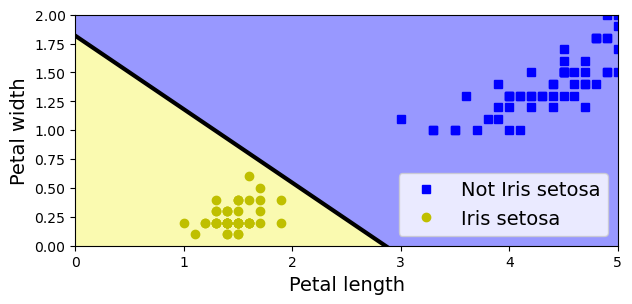

In [8]:
# extra code – plots the decision boundary of a Perceptron on the iris dataset

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.figure(figsize=(7, 3))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-",
         linewidth=3)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="lower right")
plt.axis(axes)
plt.show()

**Activation functions**

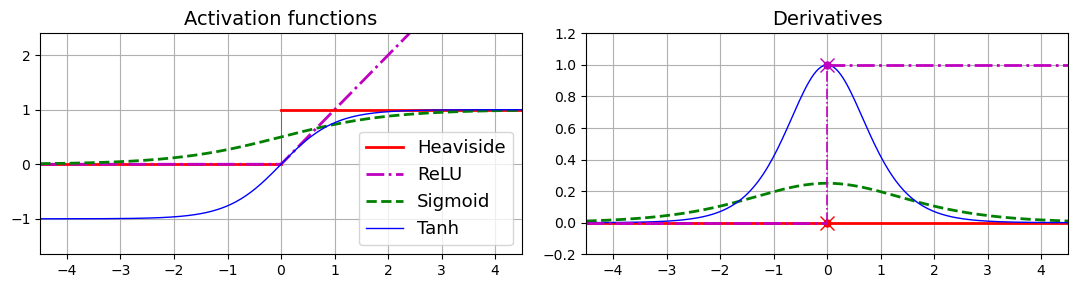

In [9]:
from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 3.1))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="Heaviside")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot([0, 0], [0, 1], "r-", linewidth=0.5)
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("Activation functions")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Heaviside")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=1.2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid(True)
plt.title("Derivatives")
plt.axis([-max_z, max_z, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

## Regression MLPs

In [10]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)

In [11]:
rmse

0.5053326657968342

## Classification MLPs

In [12]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)

mlp_clf = MLPClassifier(hidden_layer_sizes=[5], max_iter=10_000,
                        random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_valid, y_valid)
accuracy

1.0

# 3. Implementing MLPs with Keras
## Building an Image Classifier Using the Sequential API
### Using Keras to load the dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `tf.keras.datasets`. The dataset is already split for you between a training set (60,000 images) and a test set (10,000 images), but it can be useful to split the training set further to have a validation set. We'll use 55,000 images for training, and 5,000 for validation.

In [13]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [14]:
X_train.shape

(55000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [15]:
X_train.dtype

dtype('uint8')

Let's scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255:

In [16]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

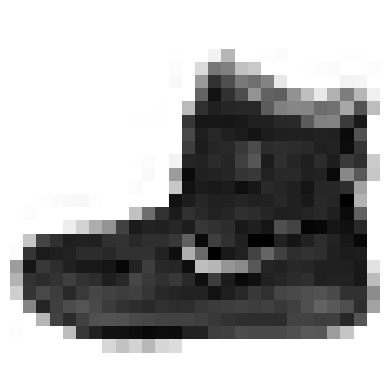

In [17]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [18]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

Here are the corresponding class names:

In [19]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is an ankle boot:

In [20]:
class_names[y_train[0]]

'Ankle boot'

Let's take a look at a sample of the images in the dataset:

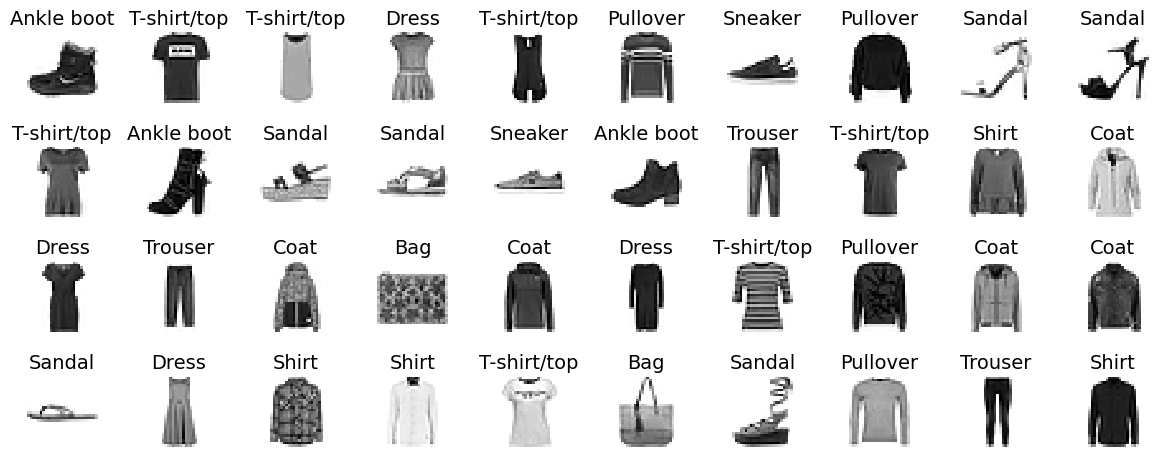

In [21]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

save_fig("fashion_mnist_plot")
plt.show()

### Creating the model using the Sequential API

In [22]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [23]:
# extra code – clear the session to reset the name counters
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
model.layers

In [26]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [27]:
model.get_layer('dense') is hidden1

True

In [28]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.06642805,  0.0556694 ,  0.01824255, ..., -0.01947625,
         0.07005356, -0.00356336],
       [-0.03184796, -0.03868344,  0.02666835, ..., -0.00064626,
        -0.05867737, -0.05255932],
       [-0.05742444,  0.03363214, -0.03931046, ..., -0.03729134,
        -0.03398697, -0.05377573],
       ...,
       [-0.04750513, -0.06413539,  0.03561822, ...,  0.0059469 ,
         0.03609095, -0.00570932],
       [ 0.02019281,  0.00031251,  0.05507872, ..., -0.06212116,
        -0.03257243,  0.0292593 ],
       [ 0.01915616, -0.07382684,  0.00604891, ..., -0.0585212 ,
        -0.03366469,  0.03644936]], dtype=float32)

In [29]:
weights.shape

(784, 300)

In [30]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [31]:
biases.shape

(300,)

### Compiling the model

In [32]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

### Training and evaluating the model

In [33]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30


1719/1719 [==============================] - 5s 2ms/step - loss: 0.7097 - accuracy: 0.7678 - val_loss: 0.5027 - val_accuracy: 0.8298
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4863 - accuracy: 0.8313 - val_loss: 0.4574 - val_accuracy: 0.8364
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4391 - accuracy: 0.8457 - val_loss: 0.4174 - val_accuracy: 0.8520
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4139 - accuracy: 0.8556 - val_loss: 0.3953 - val_accuracy: 0.8624
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3929 - accuracy: 0.8618 - val_loss: 0.3869 - val_accuracy: 0.8606
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3761 - accuracy: 0.8671 - val_loss: 0.3919 - val_accuracy: 0.8662
Epoch 7/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3636 - accuracy: 0.8709 - val_loss: 0.3657 - val_accurac

In [34]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [35]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


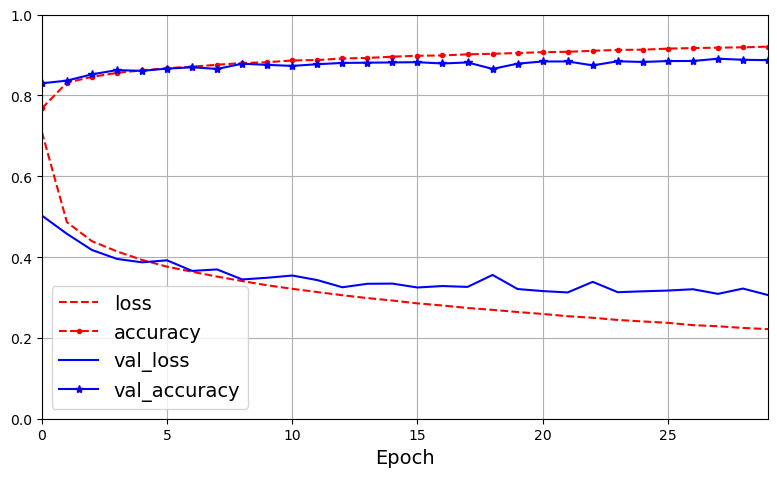

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
save_fig("keras_learning_curves_plot")  # extra code
plt.show()

In [37]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3239 - accuracy: 0.8863


[0.32394278049468994, 0.8863000273704529]

### Using the model to make predictions

In [38]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 83ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.96],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [39]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1], dtype=int64)

In [40]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [41]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

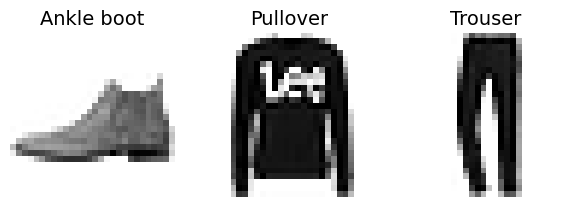

In [42]:
# extra code
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

## Building a Regression MLP Using the Sequential API

Let's load, split and scale the California housing dataset (the original one, not the modified one as in Lecture 3):

In [43]:
# extra code – load and split the California housing dataset, like earlier
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [44]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 0.8062 - root_mean_squared_error: 0.8979 - val_loss: 1.7117 - val_root_mean_squared_error: 1.3083
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3900 - root_mean_squared_error: 0.6245 - val_loss: 1.9043 - val_root_mean_squared_error: 1.3800
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3855 - root_mean_squared_error: 0.6209 - val_loss: 0.3728 - val_root_mean_squared_error: 0.6106
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3433 - root_mean_squared_error: 0.5859 - val_loss: 0.5459 - val_root_mean_squared_error: 0.7389
Epoch 5/20
363/363 [==============================] - 1s 1ms/step - loss: 0.3320 - root_mean_squared_error: 0.5762 - val_loss: 0.5471 - val_root_mean_squared_error: 0.7396
Epoch 6/20
363/363 [==============================] - 1s 1ms/step - loss: 0.3270 - root_mean_squared_error: 0.5718 - val_loss: 0.3836 - val_

In [45]:
rmse_test

0.5341909527778625

In [46]:
y_pred

array([[0.54280734],
       [1.0835394 ],
       [5.028897  ]], dtype=float32)

## Building Complex Models Using the Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [47]:
# extra code – reset the name counters and make the code reproducible
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [48]:
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

In [49]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 normalization (Normalizati  (None, 8)                    17        ['input_1[0][0]']             
 on)                                                                                              
                                                                                                  
 dense (Dense)               (None, 30)                   270       ['normalization[0][0]']       
                                                                                                  
 dense_1 (Dense)             (None, 30)                   930       ['dense[0][0]']           

In [50]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
normalization_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.3938 - root_mean_squared_error: 1.1806 - val_loss: 1.7375 - val_root_mean_squared_error: 1.3181
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4709 - root_mean_squared_error: 0.6862 - val_loss: 1.0915 - val_root_mean_squared_error: 1.0447
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3997 - root_mean_squared_error: 0.6322 - val_loss: 0.4623 - val_root_mean_squared_error: 0.6799
Epoch 4/20
363/363 [==============================] - 1s 1ms/step - loss: 0.3718 - root_mean_squared_error: 0.6097 - val_loss: 0.4695 - val_root_mean_squared_error: 0.6852
Epoch 5/20
363/363 [==============================] - 1s 1ms/step - loss: 0.3639 - root_mean_squared_error: 0.6033 - val_loss: 0.9517 - val_root_mean_squared_error: 0.9756
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3571 - root_mean_squared_error: 0.5976 - val_loss: 3.2740 - val_

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [51]:
tf.random.set_seed(42)  # extra code

In [52]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [53]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20,
                    validation_data=((X_valid_wide, X_valid_deep), y_valid))
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.2692 - root_mean_squared_error: 1.1266 - val_loss: 0.6201 - val_root_mean_squared_error: 0.7874
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4871 - root_mean_squared_error: 0.6980 - val_loss: 0.9079 - val_root_mean_squared_error: 0.9528
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4364 - root_mean_squared_error: 0.6606 - val_loss: 0.4315 - val_root_mean_squared_error: 0.6569
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4049 - root_mean_squared_error: 0.6363 - val_loss: 0.4432 - val_root_mean_squared_error: 0.6657
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3940 - root_mean_squared_error: 0.6277 - val_loss: 0.6534 - val_root_mean_squared_error: 0.8083
Epoch 6/20
363/363 [==============================] - 1s 1ms/step - loss: 0.3806 - root_mean_squared_error: 0.6169 - val_loss: 0.4161 - val_

Adding an auxiliary output for regularization:

In [54]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [55]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep],
                       outputs=[output, aux_output])

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
              metrics=["RootMeanSquaredError"])

In [57]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=20,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid))
)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.0255 - dense_2_loss: 1.8216 - dense_3_loss: 3.8613 - dense_2_root_mean_squared_error: 1.3496 - dense_3_root_mean_squared_error: 1.9650 - val_loss: 1.5127 - val_dense_2_loss: 1.2318 - val_dense_3_loss: 4.0411 - val_dense_2_root_mean_squared_error: 1.1099 - val_dense_3_root_mean_squared_error: 2.0102
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5921 - dense_2_loss: 0.5580 - dense_3_loss: 0.8988 - dense_2_root_mean_squared_error: 0.7470 - dense_3_root_mean_squared_error: 0.9481 - val_loss: 1.0323 - val_dense_2_loss: 0.8421 - val_dense_3_loss: 2.7447 - val_dense_2_root_mean_squared_error: 0.9176 - val_dense_3_root_mean_squared_error: 1.6567
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4839 - dense_2_loss: 0.4649 - dense_3_loss: 0.6553 - dense_2_root_mean_squared_error: 0.6818 - dense_3_root_mean_squared_error: 0.8095 - val_loss: 0.5747 - val_dense_2_loss

In [58]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results

162/162 [==============================] - 0s 2ms/step - loss: 0.3281 - dense_2_loss: 0.3221 - dense_3_loss: 0.3817 - dense_2_root_mean_squared_error: 0.5676 - dense_3_root_mean_squared_error: 0.6178


In [59]:
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 133ms/step


In [60]:
y_pred_tuple = model.predict((X_new_wide, X_new_deep))
y_pred = dict(zip(model.output_names, y_pred_tuple))

1/1 [==============================] - 0s 28ms/step


## Saving and Restoring a Model

In [61]:
# extra code – delete the directory, in case it already exists

import shutil

shutil.rmtree("my_keras_model", ignore_errors=True)

In [62]:
model.save("my_keras_model", save_format="tf")

INFO:tensorflow:Assets written to: my_keras_model\assets


INFO:tensorflow:Assets written to: my_keras_model\assets


In [63]:
# extra code – show the contents of the my_keras_model/ directory
for path in sorted(Path("my_keras_model").glob("**/*")):
    print(path)

my_keras_model\assets
my_keras_model\fingerprint.pb
my_keras_model\keras_metadata.pb
my_keras_model\saved_model.pb
my_keras_model\variables
my_keras_model\variables\variables.data-00000-of-00001
my_keras_model\variables\variables.index


In [64]:
model = tf.keras.models.load_model("my_keras_model")
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 93ms/step


In [65]:
model.save_weights("my_weights")

In [66]:
model.load_weights("my_weights")

In [67]:
# extra code – show the list of my_weights.* files
for path in sorted(Path().glob("my_weights.*")):
    print(path)

my_weights.data-00000-of-00001
my_weights.index


## Using Callbacks

In [68]:
shutil.rmtree("my_checkpoints", ignore_errors=True)  # extra code

In [69]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",
                                                   save_weights_only=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb])

Epoch 1/10
363/363 [==============================] - 2s 3ms/step - loss: 0.3332 - dense_2_loss: 0.3269 - dense_3_loss: 0.3897 - dense_2_root_mean_squared_error: 0.5718 - dense_3_root_mean_squared_error: 0.6243 - val_loss: 0.3268 - val_dense_2_loss: 0.3223 - val_dense_3_loss: 0.3671 - val_dense_2_root_mean_squared_error: 0.5677 - val_dense_3_root_mean_squared_error: 0.6059
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 0.3303 - dense_2_loss: 0.3243 - dense_3_loss: 0.3847 - dense_2_root_mean_squared_error: 0.5694 - dense_3_root_mean_squared_error: 0.6202 - val_loss: 0.3869 - val_dense_2_loss: 0.3733 - val_dense_3_loss: 0.5098 - val_dense_2_root_mean_squared_error: 0.6110 - val_dense_3_root_mean_squared_error: 0.7140
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.3301 - dense_2_loss: 0.3243 - dense_3_loss: 0.3823 - dense_2_root_mean_squared_error: 0.5695 - dense_3_root_mean_squared_error: 0.6183 - val_loss: 0.3137 - val_dense_2_loss

In [70]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=100,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3237 - dense_2_loss: 0.3178 - dense_3_loss: 0.3773 - dense_2_root_mean_squared_error: 0.5637 - dense_3_root_mean_squared_error: 0.6142 - val_loss: 1.1613 - val_dense_2_loss: 1.2365 - val_dense_3_loss: 0.4844 - val_dense_2_root_mean_squared_error: 1.1120 - val_dense_3_root_mean_squared_error: 0.6960
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3277 - dense_2_loss: 0.3230 - dense_3_loss: 0.3696 - dense_2_root_mean_squared_error: 0.5684 - dense_3_root_mean_squared_error: 0.6080 - val_loss: 0.8318 - val_dense_2_loss: 0.8004 - val_dense_3_loss: 1.1146 - val_dense_2_root_mean_squared_error: 0.8946 - val_dense_3_root_mean_squared_error: 1.0557
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3205 - dense_2_loss: 0.3150 - dense_3_loss: 0.3694 - dense_2_root_mean_squared_error: 0.5613 - dense_3_root_mean_squared_error: 0.6078 - val_loss: 0.3607 - val_dense_2_l

## Using TensorBoard for Visualization

TensorBoard is preinstalled on Colab, but not the `tensorboard-plugin-profile`, so let's install it:

In [71]:
%pip install -q -U tensorboard-plugin-profile

Note: you may need to restart the kernel to use updated packages.


In [72]:
shutil.rmtree("my_logs", ignore_errors=True)

In [73]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()

In [74]:
# extra code – builds the first regression model we used earlier
tf.keras.backend.clear_session()
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)

In [75]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                profile_batch=(100, 200))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb])

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.2407 - root_mean_squared_error: 1.4969 - val_loss: 1.3805 - val_root_mean_squared_error: 1.1749
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7968 - root_mean_squared_error: 0.8926 - val_loss: 0.7063 - val_root_mean_squared_error: 0.8404
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6721 - root_mean_squared_error: 0.8198 - val_loss: 0.6705 - val_root_mean_squared_error: 0.8188
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6299 - root_mean_squared_error: 0.7937 - val_loss: 0.5844 - val_root_mean_squared_error: 0.7645
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5987 - root_mean_squared_error: 0.7737 - val_loss: 0.5462 - val_root_mean_squared_error: 0.7391
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5692 - root_mean_squared_error: 0.7544 - val_loss: 0.5264 - val_

In [76]:
print("my_logs")
for path in sorted(Path("my_logs").glob("**/*")):
    print("  " * (len(path.parts) - 1) + path.parts[-1])

my_logs
  run_2023_11_28_21_06_25
    plugins
      profile
        2023_11_28_13_06_26
          ASUS-PRO16.xplane.pb
    train
      events.out.tfevents.1701176786.ASUS-PRO16.22272.0.v2
    validation
      events.out.tfevents.1701176787.ASUS-PRO16.22272.1.v2


Let's load the `tensorboard` Jupyter extension and start the TensorBoard server: 

In [77]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

Reusing TensorBoard on port 6006 (pid 19640), started 0:44:22 ago. (Use '!kill 19640' to kill it.)

**Note**: if you prefer to access TensorBoard in a separate tab, click the "localhost:6006" link below:

In [78]:
# extra code

from IPython.display import display, HTML

display(HTML('<a href="http://localhost:6006/">http://localhost:6006/</a>'))

You can use also visualize histograms, images, text, and even listen to audio using TensorBoard:

In [79]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(str(test_logdir))
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        
        data = (np.random.randn(100) + 2) * step / 100  # gets larger
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        
        images = np.random.rand(2, 32, 32, 3) * step / 1000  # gets brighter
        tf.summary.image("my_images", images, step=step)
        
        texts = ["The step is " + str(step), "Its square is " + str(step ** 2)]
        tf.summary.text("my_text", texts, step=step)
        
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

# 4. Fine-Tuning Neural Network Hyperparameters

In this section we'll use the Fashion MNIST dataset again:

In [80]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [81]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [82]:
%pip install -q -U keras_tuner

Note: you may need to restart the kernel to use updated packages.


In [83]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [84]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid))

Trial 5 Complete [00h 00m 27s]
val_accuracy: 0.8309999704360962

Best val_accuracy So Far: 0.86080002784729
Total elapsed time: 00h 02m 19s


In [85]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [86]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

{'n_hidden': 7,
 'n_neurons': 100,
 'learning_rate': 0.0012482904754698163,
 'optimizer': 'sgd'}

In [87]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 1 summary
Hyperparameters:
n_hidden: 7
n_neurons: 100
learning_rate: 0.0012482904754698163
optimizer: sgd
Score: 0.86080002784729


In [88]:
best_trial.metrics.get_last_value("val_accuracy")

0.86080002784729

In [89]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3236 - accuracy: 0.8816
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3148 - accuracy: 0.8847
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3058 - accuracy: 0.8874
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2985 - accuracy: 0.8906
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2931 - accuracy: 0.8914
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2856 - accuracy: 0.8940
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2801 - accuracy: 0.8963
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2743 - accuracy: 0.8992
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2685 - accuracy: 0.9006
Epoch 10/10
313/313 [==============================] - 1s 1ms/step - loss: 0.4038 